In [132]:
import numpy as np
from scipy import ndimage
from scipy import misc
%matplotlib inline 
import matplotlib.pyplot as plt
img = np.float32(misc.imresize(misc.imread('data/Images/lena.png'),(256,256)))/255.

In [164]:
np.divide(np.array([1,2]),np.array([[1],[2]]))

array([[1, 2],
       [0, 1]])

In [166]:
np.array([[1],[2]]).shape

(2, 1)

In [135]:
# Preamble  here 
import util
reload(util)
import numpy as np 
import sklearn
from sklearn import datasets
from scipy.sparse.linalg import eigsh
from numpy.random import permutation
from scipy import ndimage
from scipy import misc
% matplotlib inline
import matplotlib.pyplot as plt
img = np.float32(misc.imresize(misc.imread('data/Images/lena.png'),(256,256)))/255.

In [136]:
#initialization
import graph_cluster as gc
reload (gc)
params = {'eps':1, 'eta':2} # parameters for the classifier
gl_clf = gc.LaplacianClustering(scheme_type = 'GL_fidelity',  params = params)

In [137]:
gl_clf.load_raw_data(util.imageblocks(img,width = 2))

In [151]:
gl_clf.set_graph_parameters(Neig = 100,Eig_solver = 'nystrom', kernel_params = {'gamma':0.01})

In [152]:
gl_clf.build_Laplacian()

In [153]:
v = gl_clf.laplacian_matrix_['V']
e = gl_clf.laplacian_matrix_['E']

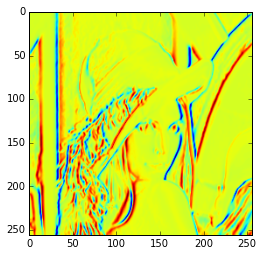

In [161]:
plt.imshow(v[:,7].reshape(img.shape[0],img.shape[1]))

In [168]:
def foo(a):
    c = a.copy()
    c[1] = 0
a = np.array([1,1])
foo(a)
print a

[1 1]


In [397]:
import scipy.sparse as spa
import numpy as np
from scipy.sparse.linalg import eigsh
from numpy.random import permutation
from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from scipy.linalg import sqrtm  
from scipy.linalg import eigh
raw_data = np.zeros([25,9,3])
for i in range(25):
    for j in range(9):
        raw_data[i,j,0] = i+j
        raw_data[i,j,1] = 2*(i+j)**2
        raw_data[i,j,2] = i*j
    
num_nystrom  = 20
kernel_flag = True
sigma = 100

if len(raw_data.shape) == 2:
    raw_data = raw_data[:,np.newaxis]
width = int((np.sqrt(raw_data.shape[1])-1)/2)
print width
n_channels = raw_data.shape[2]
raw_data = flatten_23(raw_data)
if kernel_flag: # spatial kernel involved
    kernel = make_kernel(width = width, n_channels = n_channels)
    scale_sqrt = np.sqrt(kernel).reshape(1,len(kernel))
num_rows = raw_data.shape[0]
#index = permutation(num_rows)
index = np.arange(num_rows)
sample_data = raw_data[index[:num_nystrom]]
other_data = raw_data[index[num_nystrom:]]


# calculating A
sigma = sigma*sigma 
if kernel_flag:
    A = np.exp(-cdist(sample_data*scale_sqrt,sample_data*scale_sqrt,'sqeuclidean')/sigma).astype(np.float32)
else: 
    A = np.exp(-cdist(sample_data,sample_data,'sqeuclidean')/sigma).astype(np.float32)
    #A.flat[::A.shape[0]+1] = 0

# calculating B
other_points = num_rows - num_nystrom
if kernel_flag:
    B = np.exp(-cdist(sample_data*scale_sqrt,other_data*scale_sqrt,'sqeuclidean')/sigma).astype(np.float32)
else: 
    B = np.exp(-cdist(sample_data,other_data,'sqeuclidean')/sigma).astype(np.float32)

  
    
# normalize A and B
pinv_A = pinv(A)
B_T = B.transpose()
d1 = np.sum(A,axis = 1) + np.sum(B,axis = 1)
d2 = np.sum(B_T,axis = 1) + np.dot(B_T, np.dot(pinv_A, np.sum(B,axis = 1)))
dhat = np.sqrt(1./np.concatenate((d1,d2),axis = 0))
A = A*(np.dot(dhat[0:num_nystrom,np.newaxis],dhat[0:num_nystrom,np.newaxis].transpose()))
B1 = np.dot(dhat[0:num_nystrom,np.newaxis], dhat[num_nystrom:num_nystrom+other_points,np.newaxis].transpose())
B = B*B1


# do orthogonalization and eigen-decomposition
B_T = B.transpose()
Asi = sqrtm(pinv(A))
BBT = np.dot(B,B_T)
W = np.concatenate((A,B_T), axis = 0)
R = A+ np.dot(np.dot(Asi,BBT),Asi)
R = (R+R.transpose())/2.
L, U = eigh(R)
ind = np.argsort(L)[::-1]
U = U[:,ind]
L = L[ind]
W = np.dot(W,Asi)
V = np.dot(W, U*1./np.sqrt(L))
foo = V.copy()
V[index,:] = foo
V = np.real(V)
L = 1-L

1


In [400]:
V[:,1]


array([  1.69919819e-01,   1.82242006e-01,   1.90810412e-01,
         1.93058684e-01,   1.87438548e-01,   1.74152985e-01,
         1.54734969e-01,   1.30586803e-01,   1.01943240e-01,
         6.81378543e-02,   2.84001790e-02,  -1.76138971e-02,
        -6.96244314e-02,  -1.26670480e-01,  -1.87042356e-01,
        -2.48189658e-01,  -3.06676030e-01,  -3.58236581e-01,
        -3.97955358e-01,  -4.20661360e-01,  -2.50729918e-01,
        -5.98177649e-02,  -4.84568439e-03,  -1.16945535e-04,
        -7.39346774e-07], dtype=float32)

In [299]:
flatten_23(v)

array([[ 0.12794226,  0.27247411,  0.08412802,  0.56026274,  0.7672982 ,
         0.17618314,  0.88540327,  0.74555895,  0.1828349 ],
       [ 0.82577102,  0.71412198,  0.82452278,  0.92257679,  0.49820353,
         0.84301896,  0.8047701 ,  0.92667331,  0.42358662]])

In [249]:
def make_kernel(width = None, n_channels = None):
    kernel = np.zeros([2*width+1,2*width+1])
    for d in range(1,width+1):
        value= 1. / (2*d+1.)^2 
        for i in range(-d, d+1):
            for j in range(-d, d+1): 
                kernel[width -i,width - j ] = kernel[ width - i,width - j ] + value
    kernel = kernel/width
    kernel = kernel.flatten()
    kernel = np.array([kernel, ]*n_channels)
    kernel = kernel.flatten()
    return kernel

In [251]:
def make_kernel(width = None, n_channels = None):
    kernel = np.zeros([2*width+1,2*width+1])
    for d in range(1,width+1):
        value= 1. / ((2*d+1.)*(2*d+1.))
        for i in range(-d, d+1):
            for j in range(-d, d+1): 
                kernel[width -i,width - j ] = kernel[ width - i,width - j ] + value
    kernel = kernel/width
    kernel = kernel.flatten()
    kernel = np.array([kernel, ]*n_channels)
    kernel = kernel.flatten()
    return kernel

In [252]:
k = make_kernel(2,1)

In [253]:
k

array([ 0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
        0.02      ,  0.07555556,  0.07555556,  0.07555556,  0.02      ,
        0.02      ,  0.07555556,  0.07555556,  0.07555556,  0.02      ,
        0.02      ,  0.07555556,  0.07555556,  0.07555556,  0.02      ,
        0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ])

In [224]:
k[:25].reshape([5,5])

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  2.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [70]:
foo[:,:,1]

array([[ 1.83749359,  0.31517782,  0.57730257, -1.10501861, -0.89021151,
         0.30982067],
       [-1.14147446, -0.42307415,  0.07050621,  0.70867843, -1.33972705,
         1.28989635],
       [ 1.17967366, -0.55043807, -0.70357047, -0.66262449, -0.71236815,
        -2.64986493],
       [-0.73828102, -0.85496308, -0.46720098,  0.28434462,  2.12362476,
        -0.69400875]])

In [68]:
np.lib.stride_tricks.as_strided(foo, shape=(2,), strides=[foo.itemsize*1])

array([ 0.97095326,  1.83749359])

In [63]:
foo.itemsize

8

array([ 8,  2,  0,  0,  2,  8, 18,  4,  1,  0,  0,  1,  4,  9,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  0,  0,  1,  4,
        9,  8,  2,  0,  0,  2,  8, 18, 12,  3,  0,  0,  3, 12, 27])